In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [2]:
with open("/root/data/smartwatch/subjects/valid_files.txt") as f:
    valid_files = f.readlines()
    valid_files = [x.strip() for x in valid_files]

In [3]:
all_samples = {}
global_vals = {}

data_dir = "/root/data/smartwatch/subjects"
for valid_file in tqdm(valid_files):
    subject = valid_file
    if "B" in subject.split("/")[0]:
        exercise = int(subject.split("/")[1][6]) 
    else:
        exercise = int(subject.split("/")[1][5]) 

    df_imu = pd.read_csv(data_dir + f"/{subject}_imu.csv")

    # Rename sensors
    df_imu.loc[df_imu[" Sensor Type"] == 1, " Sensor Type"] = "Accelerometer"
    df_imu.loc[df_imu[" Sensor Type"] == 2, " Sensor Type"] = "Magnetometer"
    df_imu.loc[df_imu[" Sensor Type"] == 4, " Sensor Type"] = "Gyroscope"

    if len(df_imu[" Sensor Type"].unique()) < 3:
        print(df_imu[" Sensor Type"].unique() + " data present in sample.")
    for sensor_type in df_imu[" Sensor Type"].unique():
        subdf = df_imu.loc[df_imu[" Sensor Type"] == sensor_type, :]

        # Compute stdev for sensor
        #sensor_std = np.std(np.stack((subdf["channel1"].values, subdf["val2"].values, subdf["val3"].values)), axis=0)

        # Add to all sample data
  
        # Update values
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_1", {}).setdefault("vals", []).append(subdf["val1"].values)
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_2", {}).setdefault("vals", []).append(subdf["val3"].values)
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_3", {}).setdefault("vals", []).append(subdf["val2"].values)

        # Update std and mean
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_1", {}).setdefault("std", []).append(round(np.std(subdf["val1"].values), 1))
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_2", {}).setdefault("std", []).append(round(np.std(subdf["val2"].values), 1))
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_3", {}).setdefault("std", []).append(round(np.std(subdf["val3"].values), 1))

        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_1", {}).setdefault("mean", []).append(round(np.mean(subdf["val1"].values), 1))
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_2", {}).setdefault("mean", []).append(round(np.mean(subdf["val2"].values), 1))
        all_samples.setdefault(exercise, {}).setdefault(sensor_type, {}).setdefault("channel_3", {}).setdefault("mean", []).append(round(np.mean(subdf["val3"].values), 1))

        global_vals.setdefault(sensor_type, {}).setdefault("channel_1", Counter()).update(subdf["val1"].values)
        global_vals.setdefault(sensor_type, {}).setdefault("channel_2", Counter()).update(subdf["val2"].values)
        global_vals.setdefault(sensor_type, {}).setdefault("channel_3", Counter()).update(subdf["val3"].values)

        # # Get outliers and their location that are greater than 3 stdevs
        # channels = ["val1", "val2", "val3"]
        # for channel in channels:
        #     for i, val in enumerate(subdf[channel]):
        #         all_samples[exercise][sensor_type][channel].update({'norm': (subdf[channel]-all_samples[exercise][sensor_type][channel]['mean'][-1])/all_samples[exercise][sensor_type][channel]['std'][-1]})
        #         if val > -3*all_samples[exercise][sensor_type][channel]['std'][-1] + all_samples[exercise][sensor_type][channel]['mean'][-1] or val > 3*all_samples[exercise][sensor_type][channel]['std'][-1] + all_samples[exercise][sensor_type][channel]['mean'][-1]:
        #             all_samples[exercise][sensor_type][channel].setdefault("outliers",{"sample": subject, "channel": channel, "val": val, "loc": i, "percent": round((i+1)/len(subdf[channel]),4)})

 56%|█████▌    | 370/665 [00:12<00:10, 29.01it/s]

['Magnetometer data present in sample.'
 'Gyroscope data present in sample.']


 91%|█████████ | 606/665 [00:19<00:01, 34.65it/s]

['Magnetometer data present in sample.'
 'Gyroscope data present in sample.']


100%|██████████| 665/665 [00:21<00:00, 30.81it/s]


In [10]:
global_stats = {}
sensor_channels = []
stds = []
means = []
for sensor_type in global_vals.keys():
    for channel in global_vals[sensor_type].keys():
        elements = np.array([el for el in global_vals[sensor_type][channel].elements()])
        global_stats.setdefault(sensor_type, {}).setdefault(channel, {}).setdefault("std", np.round(np.std(elements), 4))
        global_stats.setdefault(sensor_type, {}).setdefault(channel, {}).setdefault("mean", np.round(np.mean(elements), 4))
        sensor_channels.append(sensor_type[0].lower()+ "_"+ channel[-1])
        stds.append(np.round(np.std(elements), 4))
        means.append(np.round(np.mean(elements), 4))

In [8]:
global_stats['Accelerometer'].keys()


dict_keys(['channel_1', 'channel_2', 'channel_3'])

In [16]:
df_gs = pd.DataFrame({'sensor_channels': sensor_channels, "std": stds, "mean": means})
df_gs.to_csv("./inputs_global_stats.csv", index=False)

In [33]:
global_samples = {}
exercise_samples = {}

outliers_scale = 3

for exercise in tqdm(all_samples.keys()):
    for sensor_type in all_samples[exercise].keys():
        for channel in all_samples[exercise][sensor_type].keys():
            exercise_samples.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("std", {}).setdefault(channel, Counter()).update(all_samples[exercise][sensor_type][channel]['std'])
            exercise_samples.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("mean", {}).setdefault(channel, Counter()).update(all_samples[exercise][sensor_type][channel]['mean'])

            global_samples.setdefault(sensor_type,{}).setdefault("std", {}).setdefault(channel, Counter()).update(all_samples[exercise][sensor_type][channel]['std'])
            global_samples.setdefault(sensor_type,{}).setdefault("mean", {}).setdefault(channel, Counter()).update(all_samples[exercise][sensor_type][channel]['mean'])
            
            for i, vals in enumerate(all_samples[exercise][sensor_type][channel]['vals']):
                exercise_samples.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("vals", {}).setdefault(channel, Counter()).update(vals)
                global_samples.setdefault(sensor_type,{}).setdefault("vals", {}).setdefault(channel, Counter()).update(vals)

                exercise_samples.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("norms", {}).setdefault(channel, Counter()).update(np.round((vals - global_stats[sensor_type][channel]['mean']) / global_stats[sensor_type][channel]['std'], 4))
                global_samples.setdefault(sensor_type,{}).setdefault("norms", {}).setdefault(channel, Counter()).update(np.round((vals - global_stats[sensor_type][channel]['mean']) / global_stats[sensor_type][channel]['std'], 4))

                outlier_idx = np.where((vals < -outliers_scale*global_stats[sensor_type][channel]['std'] + global_stats[sensor_type][channel]['mean']) | (vals > outliers_scale*global_stats[sensor_type][channel]['std'] + global_stats[sensor_type][channel]['mean']))[0]
                outlier_perc = np.round(outlier_idx / len(vals), 3)

                exercise_samples.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("outliers", {}).setdefault(channel, Counter()).update(outlier_perc)
                global_samples.setdefault(sensor_type,{}).setdefault("outliers", {}).setdefault(channel, Counter()).update(outlier_perc)



                # exercise_stats.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("vals", {}).setdefault(channel, Counter()).update(vals)
                # global_stats.setdefault(sensor_type,{}).setdefault("vals", {}).setdefault(channel, Counter()).update(vals)

                # exercise_stats.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("norms", {}).setdefault(channel, Counter()).update(np.round((vals - all_samples[exercise][sensor_type][channel]['mean'][i]) / all_samples[exercise][sensor_type][channel]['std'][i], 4))
                # global_stats.setdefault(sensor_type,{}).setdefault("norms", {}).setdefault(channel, Counter()).update(np.round((vals - all_samples[exercise][sensor_type][channel]['mean'][i]) / all_samples[exercise][sensor_type][channel]['std'][i], 4))

                # outlier_idx = np.where((vals < -outliers_scale*all_samples[exercise][sensor_type][channel]['std'][i] + all_samples[exercise][sensor_type][channel]['mean'][i]) | (vals > outliers_scale*all_samples[exercise][sensor_type][channel]['std'][i] + all_samples[exercise][sensor_type][channel]['mean'][i]))[0]
                # outlier_perc = np.round(outlier_idx / len(vals), 4)

                # exercise_stats.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("outliers", {}).setdefault(channel, Counter()).update(outlier_perc)
                # global_stats.setdefault(sensor_type,{}).setdefault("outliers", {}).setdefault(channel, Counter()).update(outlier_perc)

# # Get outliers and their locatio

100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Find outliers and where they occur.

In [38]:
outliers_global_stats = {}
outliers_exercise_stats = {}
for exercise in all_samples.keys():
    for sensor_type in all_samples[exercise].keys():
        for channel in all_samples[exercise][sensor_type].keys():
            for i, vals in enumerate(all_samples[exercise][sensor_type][channel]['vals']):
                outlier_idx = np.where((vals < -outliers_scale*all_samples[exercise][sensor_type][channel]['std'][i] + all_samples[exercise][sensor_type][channel]['mean'][i]) | (vals > outliers_scale*all_samples[exercise][sensor_type][channel]['std'][i] + all_samples[exercise][sensor_type][channel]['mean'][i]))[0]
                outlier_perc = np.round(outlier_idx / len(vals), 4)

                exercise_samples.setdefault(exercise, {}).setdefault(sensor_type,{}).setdefault("outliers", {}).setdefault(channel, Counter()).update(outlier_perc)
                global_samples.setdefault(sensor_type,{}).setdefault("outliers", {}).setdefault(channel, Counter()).update(outlier_perc)

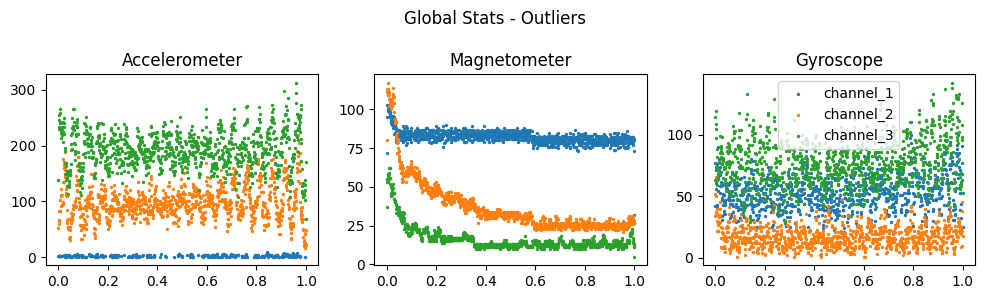

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

for ax, sensor_type in zip(axs, global_samples.keys()):    
    for channel, counter in global_samples[sensor_type]['outliers'].items():
        #ax = axs[ax_idx]
        ax.scatter(counter.keys(), counter.values(), s=2, label=channel)
    ax.set_title(sensor_type)
        #ax_idx = ax_idx + 1
fig.suptitle("Global Stats - Outliers")
plt.legend()
plt.tight_layout()
plt.show()

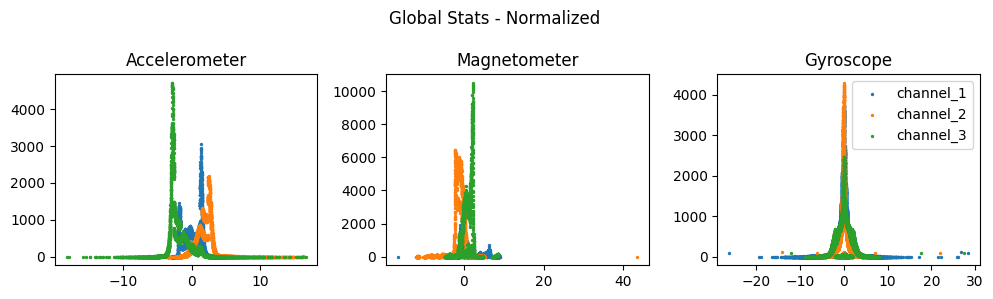

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

for ax, sensor_type in zip(axs, global_samples.keys()):    
    for channel, counter in global_samples[sensor_type]['norms'].items():
        #ax = axs[ax_idx]
        ax.scatter(counter.keys(), counter.values(), s=2, label=channel)
    ax.set_title(sensor_type)
        #ax_idx = ax_idx + 1
fig.suptitle("Global Stats - Normalized")
plt.legend()
plt.tight_layout()
plt.show()

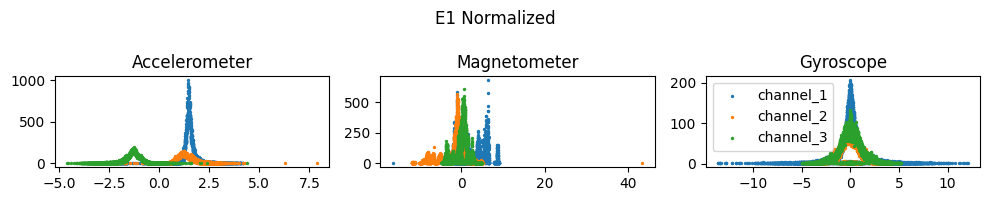

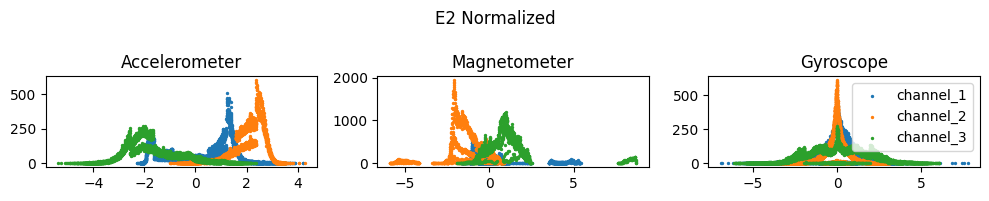

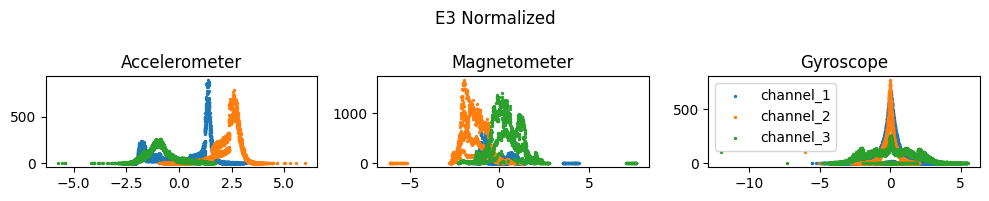

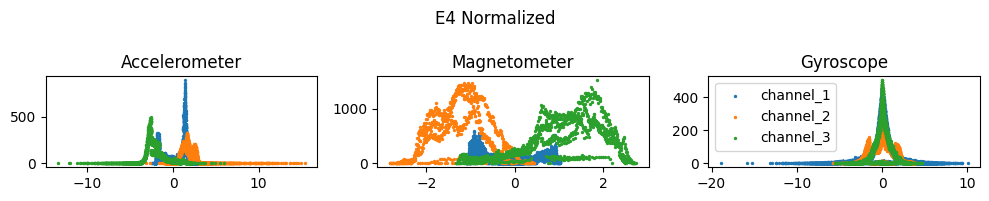

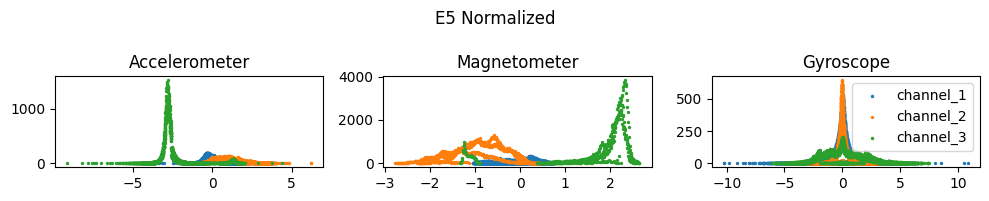

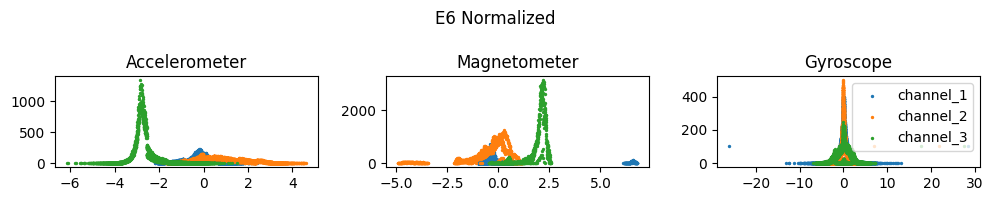

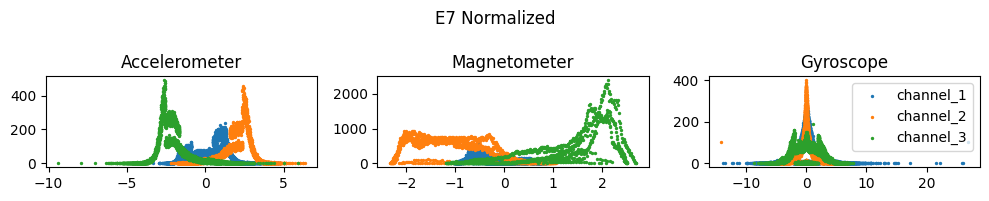

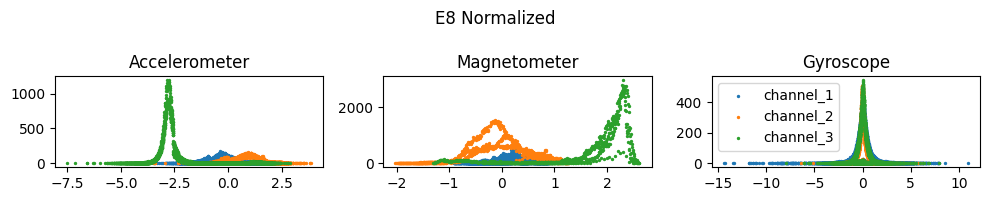

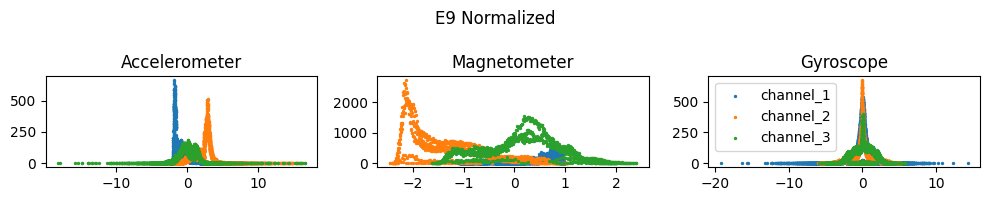

In [31]:
for exercise in exercise_samples.keys():
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    axs = axs.flatten()
    for ax, sensor_type in zip(axs, exercise_samples[exercise].keys()):
        for channel, counter in exercise_samples[exercise][sensor_type]['norms'].items():
            ax.scatter(counter.keys(), counter.values(), s=2, label=channel)
        ax.set_title(sensor_type)
    fig.suptitle("E" + str(exercise) + " Normalized")
    plt.tight_layout()
    plt.legend()
    plt.show()

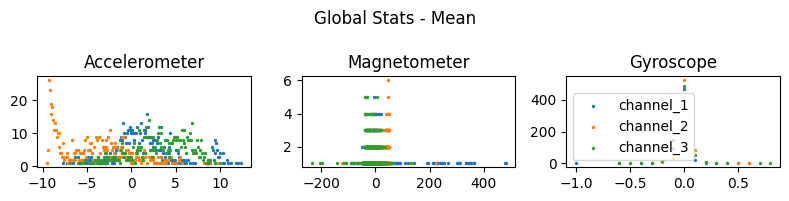

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2))
axs = axs.flatten()

for ax, sensor_type in zip(axs, global_samples.keys()):
    for channel, counter in global_samples[sensor_type]['mean'].items():
        ax.scatter(counter.keys(), counter.values(), s=2, label=channel)
    ax.set_title(sensor_type)
fig.suptitle("Global Stats - Mean")
plt.tight_layout()
plt.legend()
plt.show()

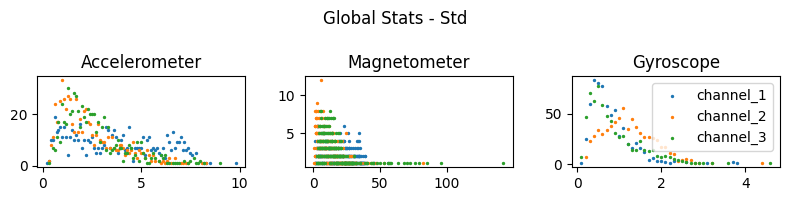

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2))
axs = axs.flatten()

for ax, sensor_type in zip(axs, global_samples.keys()):
    for channel, counter in global_samples[sensor_type]['std'].items():
        ax.scatter(counter.keys(), counter.values(), s=2, label=channel)
    ax.set_title(sensor_type)
fig.suptitle("Global Stats - Std")
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
for sensor_type in global_samples.keys():
    fig, axs = plt.subplots(1, 3, figsize=(8, 2))
    axs = axs.flatten()
    for ax, (channel, counter) in zip(axs, global_samples[sensor_type]['std'].items()):
        #ax = axs[ax_idx]
        ax.scatter(counter.keys(), counter.values(), s=2)
        ax.set_title(channel)
        #ax_idx = ax_idx + 1
    fig.suptitle(sensor_type)
    plt.tight_layout()
    plt.show()

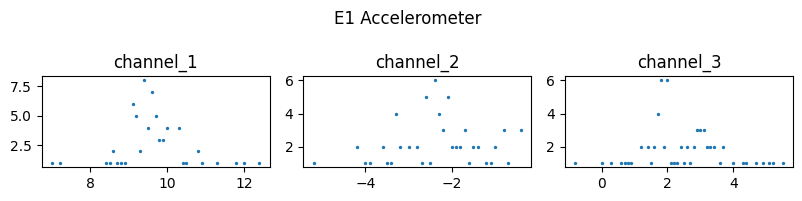

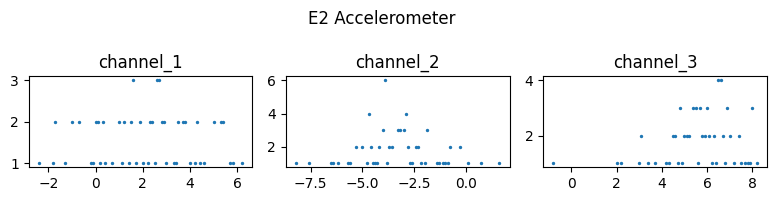

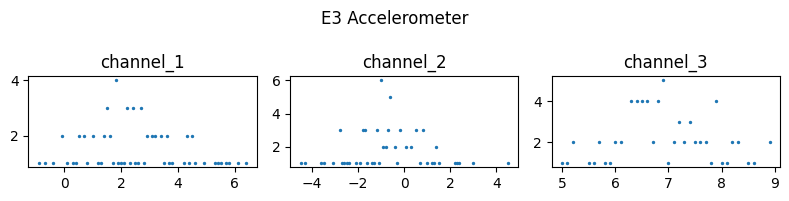

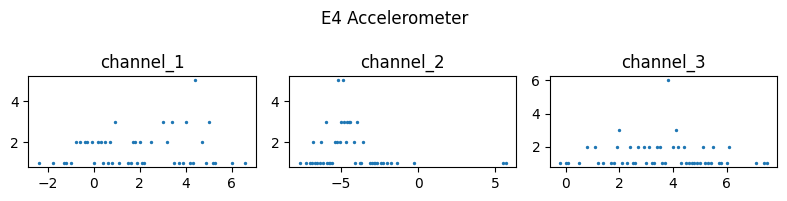

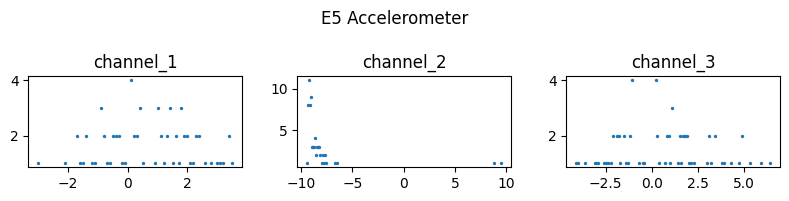

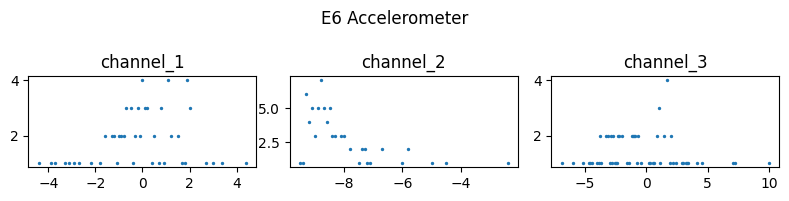

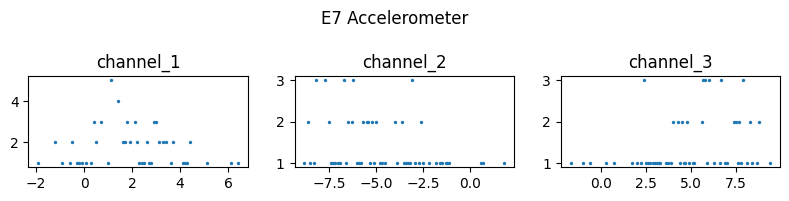

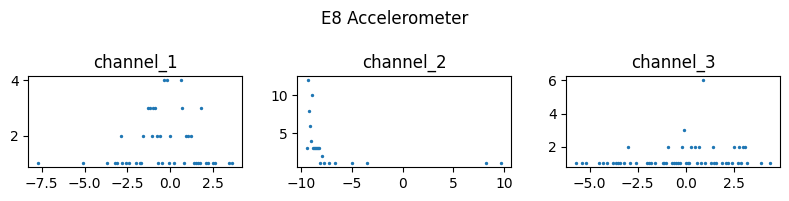

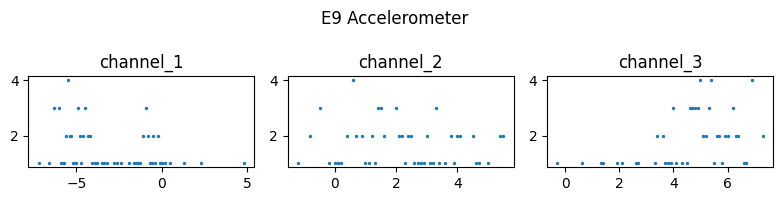

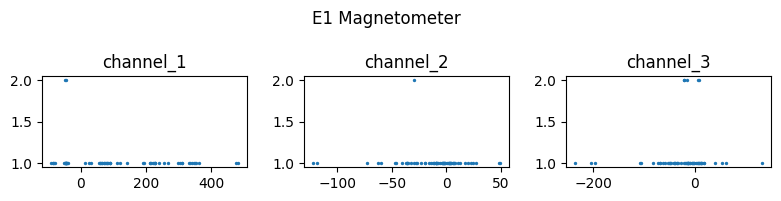

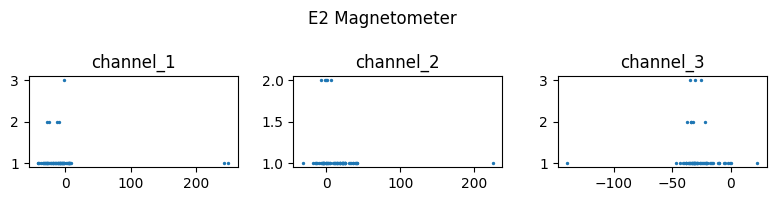

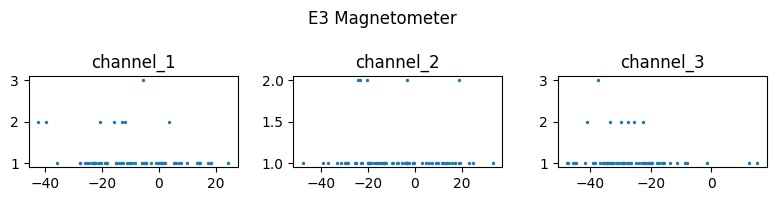

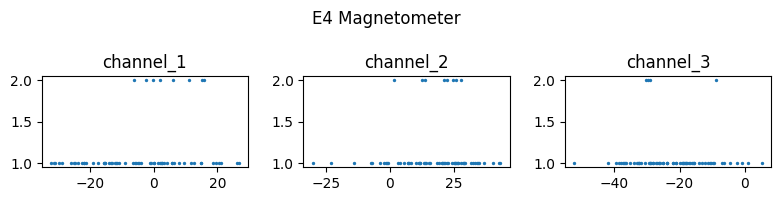

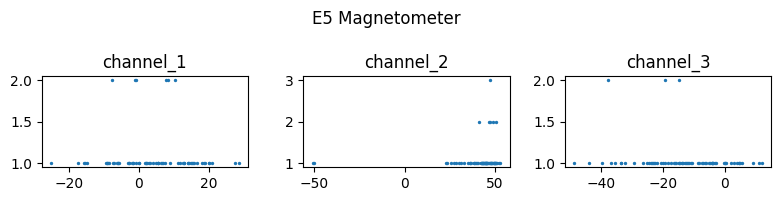

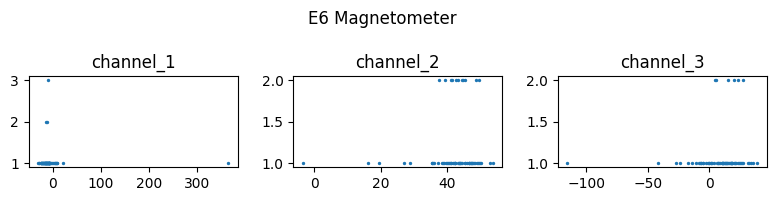

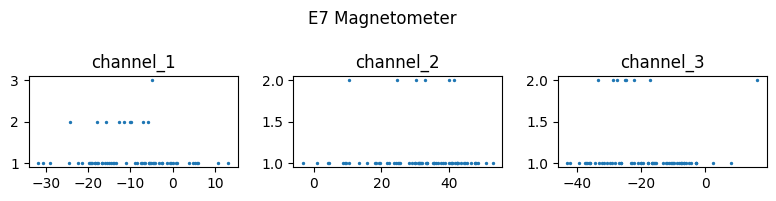

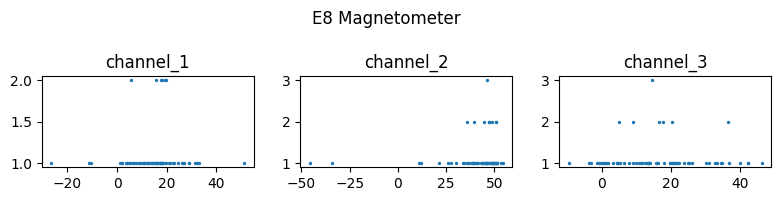

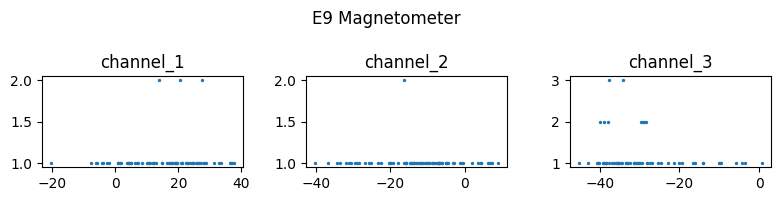

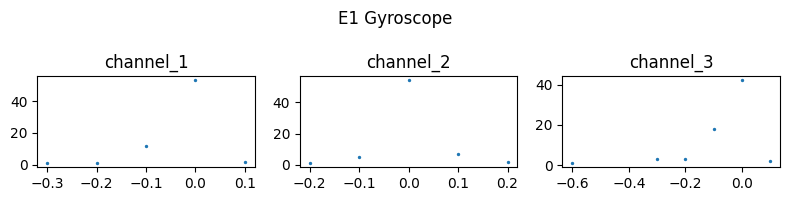

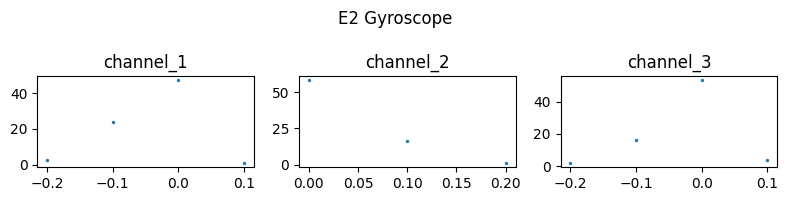

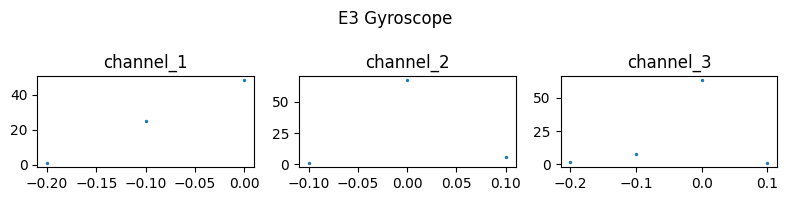

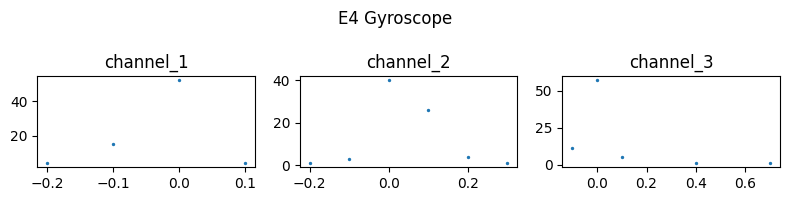

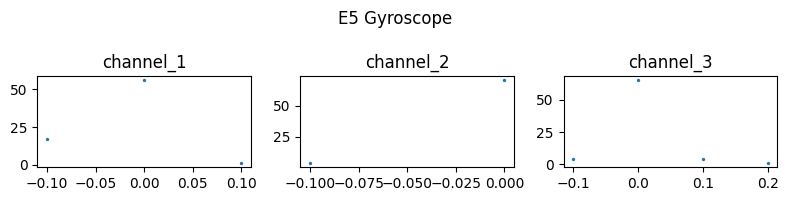

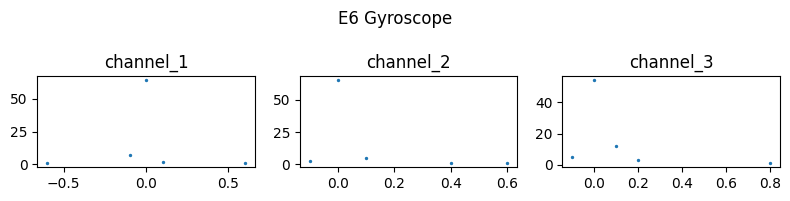

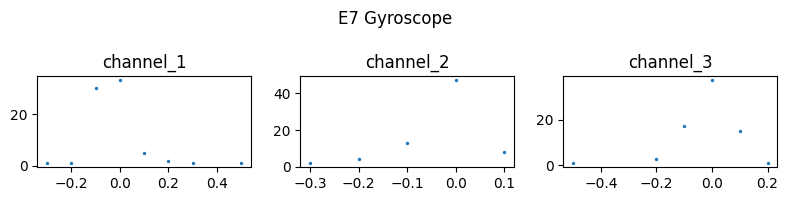

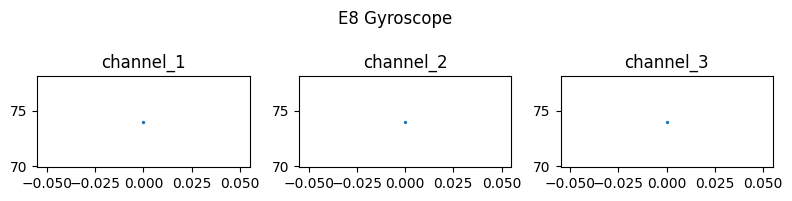

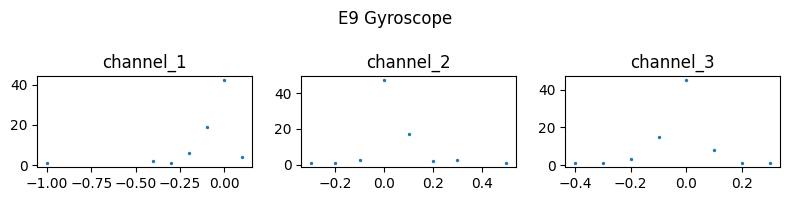

In [ ]:
exercise = 1
for sensor_type in exercise_samples[exercise].keys():
    for exercise in exercise_samples.keys():
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        axs = axs.flatten()
        for ax, (channel, counter) in zip(axs, exercise_samples[exercise][sensor_type]['mean'].items()):
            #ax = axs[ax_idx]
            ax.scatter(counter.keys(), counter.values(), s=2)
            ax.set_title(channel)
            #ax_idx = ax_idx + 1
        fig.suptitle("E" + str(exercise) + " " + sensor_type)
        plt.tight_layout()
        plt.show()

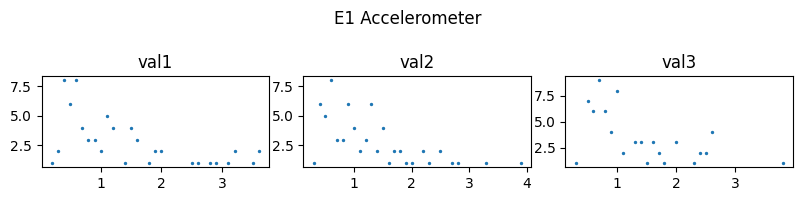

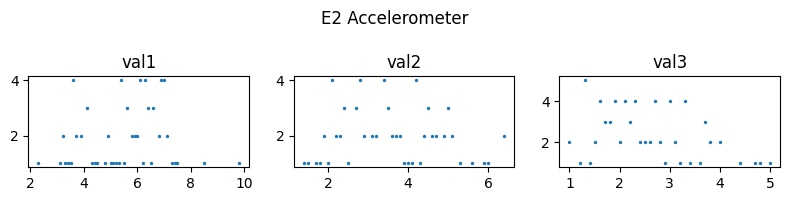

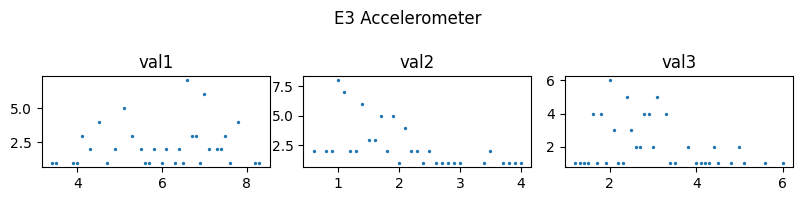

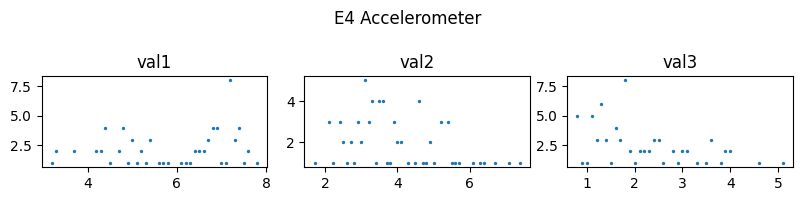

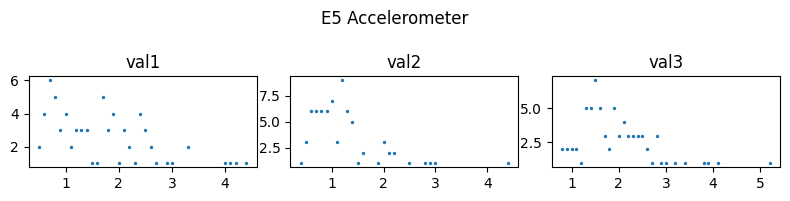

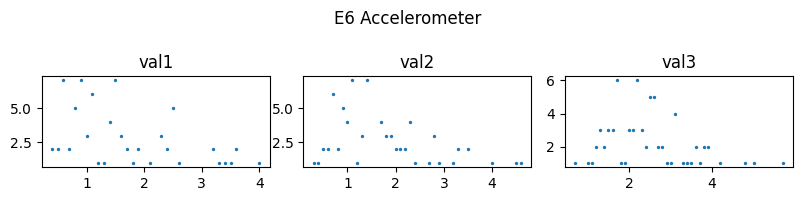

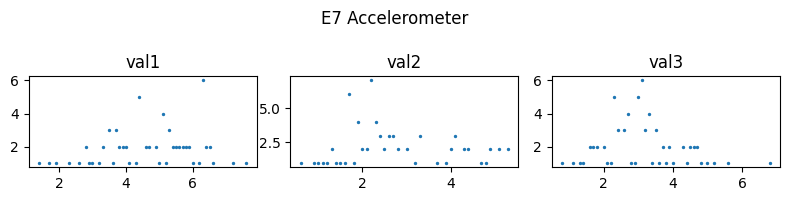

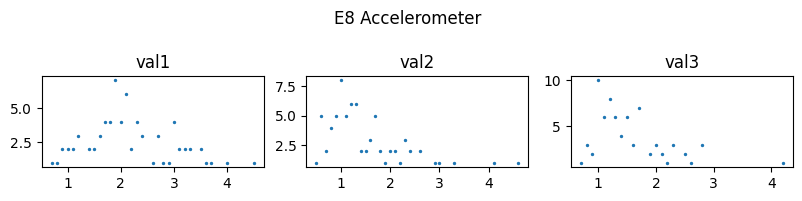

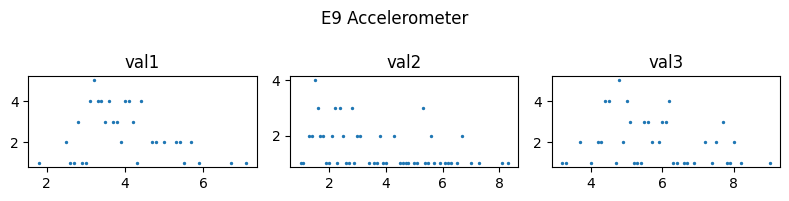

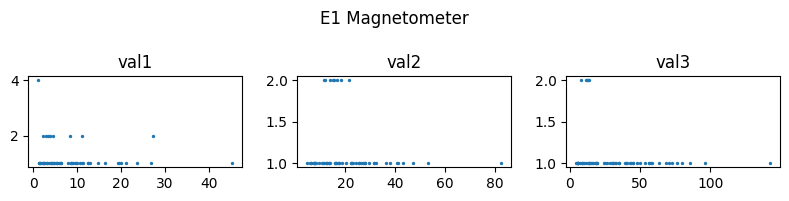

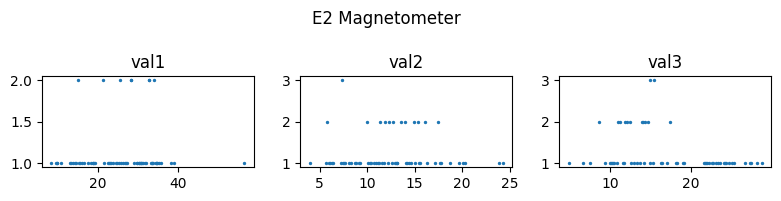

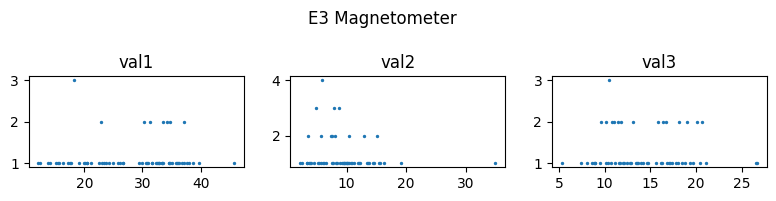

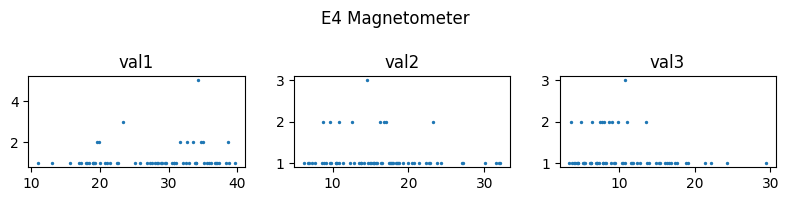

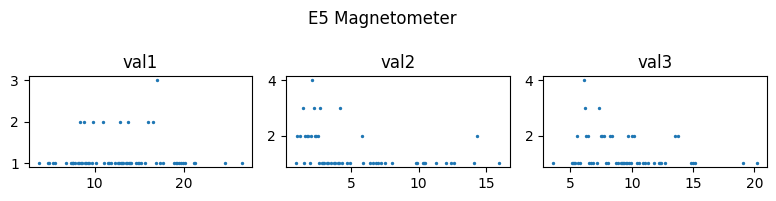

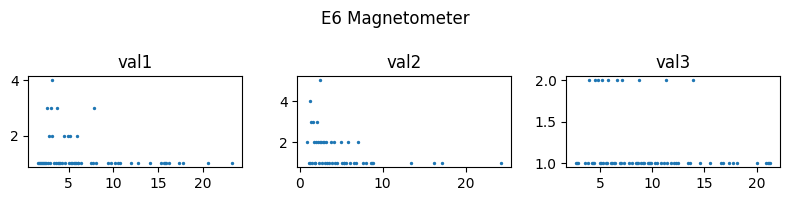

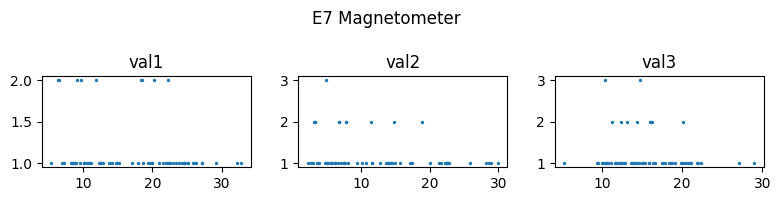

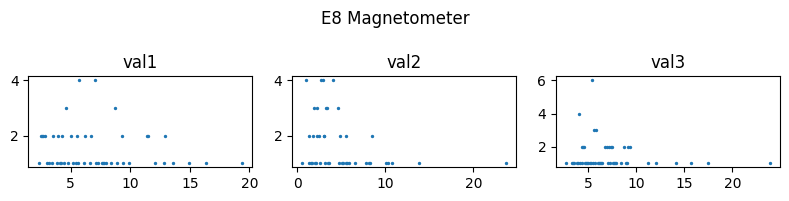

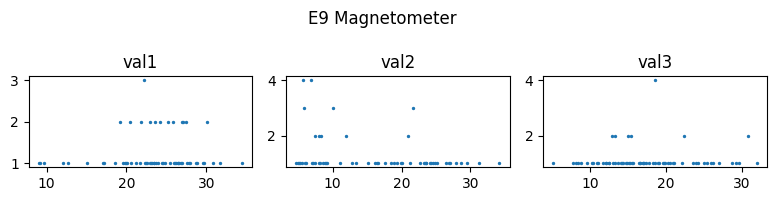

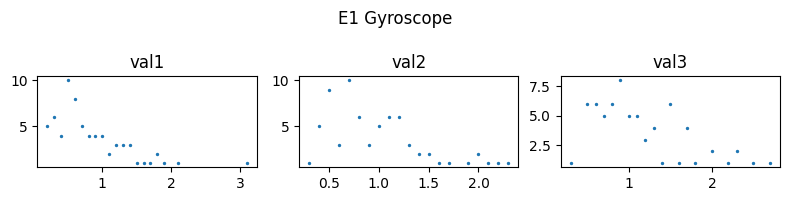

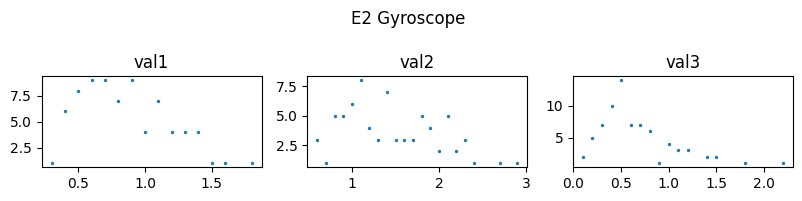

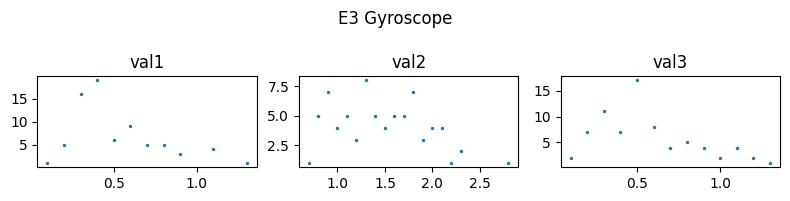

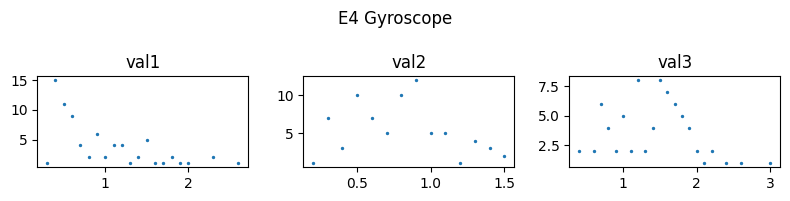

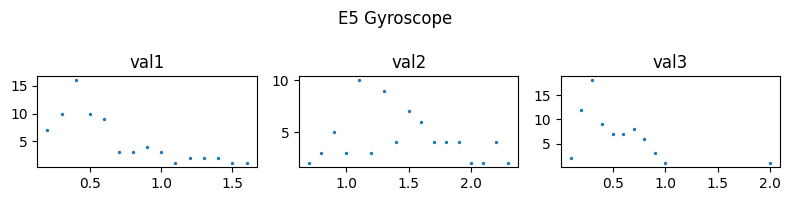

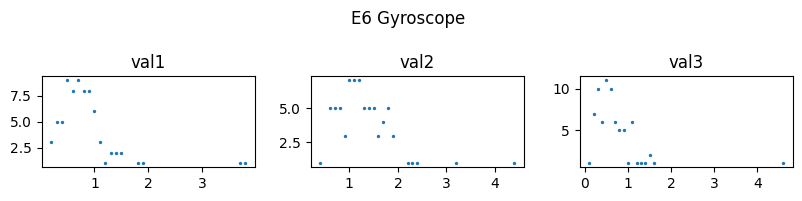

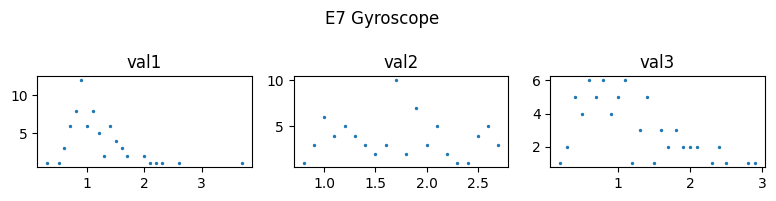

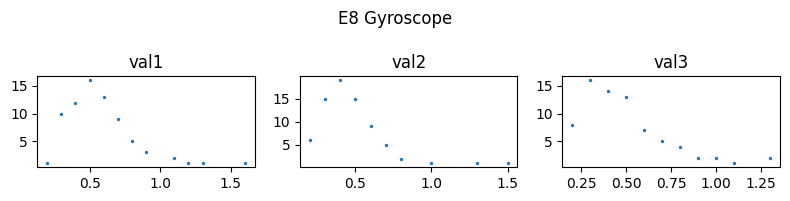

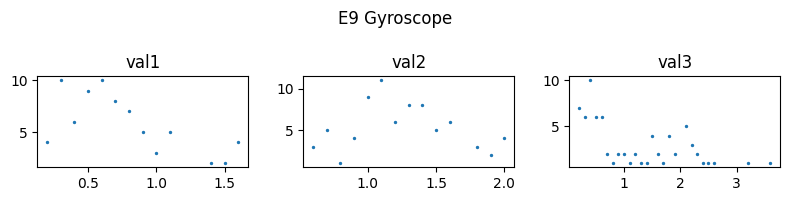

In [ ]:
exercise = 1
for sensor_type in exercise_stats[exercise].keys():
    for exercise in exercise_stats.keys():
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        axs = axs.flatten()
        for ax, (channel, counter) in zip(axs, exercise_stats[exercise][sensor_type]['std'].items()):
            #ax = axs[ax_idx]
            ax.scatter(counter.keys(), counter.values(), s=2)
            ax.set_title(channel)
            #ax_idx = ax_idx + 1
        fig.suptitle("E" + str(exercise) + " " + sensor_type)
        plt.tight_layout()
        plt.show()

In [ ]:
data_dir = "/root/data/smartwatch/subjects"
subject = valid_files[2]

df_imu = pd.read_csv(data_dir + f"/{subject}_imu.csv")

# Rename sensors
df_imu.loc[df_imu[" Sensor Type"] == 1, " Sensor Type"] = "Accelerometer"
df_imu.loc[df_imu[" Sensor Type"] == 2, " Sensor Type"] = "Magnetometer"
df_imu.loc[df_imu[" Sensor Type"] == 4, " Sensor Type"] = "Gyroscope"
df_imu

,Sample Time [s],Sensor Type,val1,val2,val3
0,0.000000,Accelerometer,7.867188,-4.839844,6.875000
1,0.010224,Accelerometer,7.781250,-4.851562,6.808594
2,0.020185,Accelerometer,7.730469,-4.953125,6.824219
3,0.030409,Accelerometer,7.667969,-4.996094,6.765625
4,0.040370,Accelerometer,7.671875,-4.917969,6.671875
...,...,...,...,...,...
11896,40.213413,Magnetometer,-31.125000,0.899902,-44.875000
11897,40.215250,Gyroscope,-0.838379,-1.767578,0.060638
11898,40.147617,Accelerometer,4.980469,-4.667969,11.015625
11899,40.223637,Magnetometer,-32.156250,2.699219,-44.281250


In [ ]:
df_imu["Sample Time [s]"]

0         0.000000
1         0.010224
2         0.020185
3         0.030409
4         0.040370
           ...    
11896    40.213413
11897    40.215250
11898    40.147617
11899    40.223637
11900    40.225212
Name: Sample Time [s], Length: 11901, dtype: float64

In [ ]:
df_imu.columns

Index(['Sample Time [s]', ' Sensor Type', 'val1', 'val2', 'val3'], dtype='object')

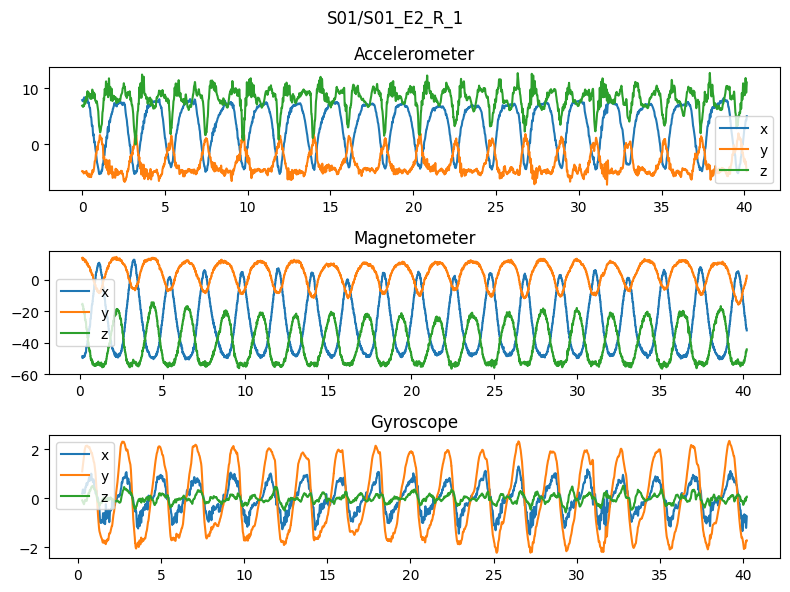

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
for ax, sensor_type in zip(axs, df_imu[" Sensor Type"].unique()):
    subdf = df_imu.loc[df_imu[" Sensor Type"] == sensor_type, :]
    t = subdf["Sample Time [s]"].values
    x = subdf["val1"].values
    y = subdf["val2"].values
    z = subdf["val3"].values
    ax.plot(t, x, label="x")
    ax.plot(t, y, label="y")
    ax.plot(t, z, label="z")
    ax.set_title(sensor_type)
    ax.legend()
plt.suptitle(subject)
plt.tight_layout()
plt.show()

In [ ]:
df_mocap = pd.read_csv(data_dir + f"/{subject}_mocap.csv", skiprows=2)
df_mocap

,Unnamed: 0,Unnamed: 1,S01_cal:C7,Unnamed: 3,Unnamed: 4,S01_cal:L5,Unnamed: 6,Unnamed: 7,S01_cal:SS,Unnamed: 9,...,S01_cal:L_FA3,Unnamed: 93,Unnamed: 94,S01_cal:L_MCP5,Unnamed: 96,Unnamed: 97,S01_cal:L_MCP2,Unnamed: 99,Unnamed: 100,Unnamed: 101
0,Frame,Sub Frame,X,Y,Z,X,Y,Z,X,Y,...,X,Y,Z,X,Y,Z,X,Y,Z,NaN
1,NaN,NaN,mm,mm,mm,mm,mm,mm,mm,mm,...,mm,mm,mm,mm,mm,mm,mm,mm,mm,NaN
2,1,0,786.807,248.755,1481.84,855.211,287.019,1019.94,649.115,224.464,...,964.891,-34.0731,931.151,974.99,-57.6467,777.005,889.742,-34.1957,779.704,NaN
3,2,0,786.828,248.91,1481.87,855.317,286.834,1019.89,649.155,224.62,...,964.897,-33.7137,931.133,974.937,-57.2435,777.031,889.672,-33.8417,779.76,NaN
4,3,0,786.88,249.025,1481.88,855.428,286.677,1019.91,649.223,224.806,...,964.54,-33.3331,931.029,974.459,-56.8342,776.87,889.202,-33.4329,779.66,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007,4006,0,782.658,187.186,1470.33,872.749,262.506,1019.35,651.569,237.898,...,397.389,109.842,960.546,299.092,154.941,855.372,255.079,184.015,925.818,NaN
4008,4007,0,782.386,187.825,1470.55,872.755,262.546,1019.43,651.158,237.608,...,406.088,106.348,954.683,309.534,150.394,847.344,264.117,179.806,916.813,NaN
4009,4008,0,782.124,188.492,1470.78,872.787,262.621,1019.48,650.809,237.277,...,414.902,102.808,948.986,320.193,145.736,839.641,273.347,175.522,907.937,NaN
4010,4009,0,782.177,189.266,1471.03,872.765,262.655,1019.53,650.417,236.97,...,423.73,99.2621,943.489,331.066,141.309,832.02,282.719,171.333,899.189,NaN


We care about markers on the radial styloid (RS) and ulnar styloid (US) on the wrist of the right arm.

For orientation:
- X represents "forward"
- Y represents "up"
- Z represents "right"

In [ ]:
i = df_mocap.columns.tolist().index("S01_cal:R_US")
us_inds = [i, i+1, i+2]

i = df_mocap.columns.tolist().index("S01_cal:R_RS") 
rs_inds = [i, i+1, i+2]

In [ ]:
df_rs = df_mocap.iloc[2:, rs_inds]
df_rs.columns = [f"R_RS_{pos}" for pos in "XYZ"]
df_rs = df_rs.astype(float)
df_rs

,R_RS_X,R_RS_Y,R_RS_Z
2,391.959,214.845,964.939
3,391.782,214.934,965.027
4,391.322,215.122,965.243
5,390.665,215.418,965.570
6,389.740,215.774,966.024
...,...,...,...
4007,228.833,402.357,1457.820
4008,227.076,402.007,1446.920
4009,225.494,401.526,1435.900
4010,224.072,400.947,1424.740


In [ ]:
df_us = df_mocap.iloc[2:, us_inds]
df_us.columns = [f"R_US_{pos}" for pos in "XYZ"]
df_us = df_us.astype(float)
df_us

,R_US_X,R_US_Y,R_US_Z
2,381.299,263.313,936.094
3,381.132,263.387,936.160
4,380.747,263.582,936.392
5,380.083,263.858,936.739
6,379.169,264.267,937.216
...,...,...,...
4007,221.299,459.917,1455.200
4008,219.459,459.484,1443.810
4009,217.863,459.010,1432.310
4010,216.408,458.363,1420.720


In [ ]:
len(df_rs)

4010

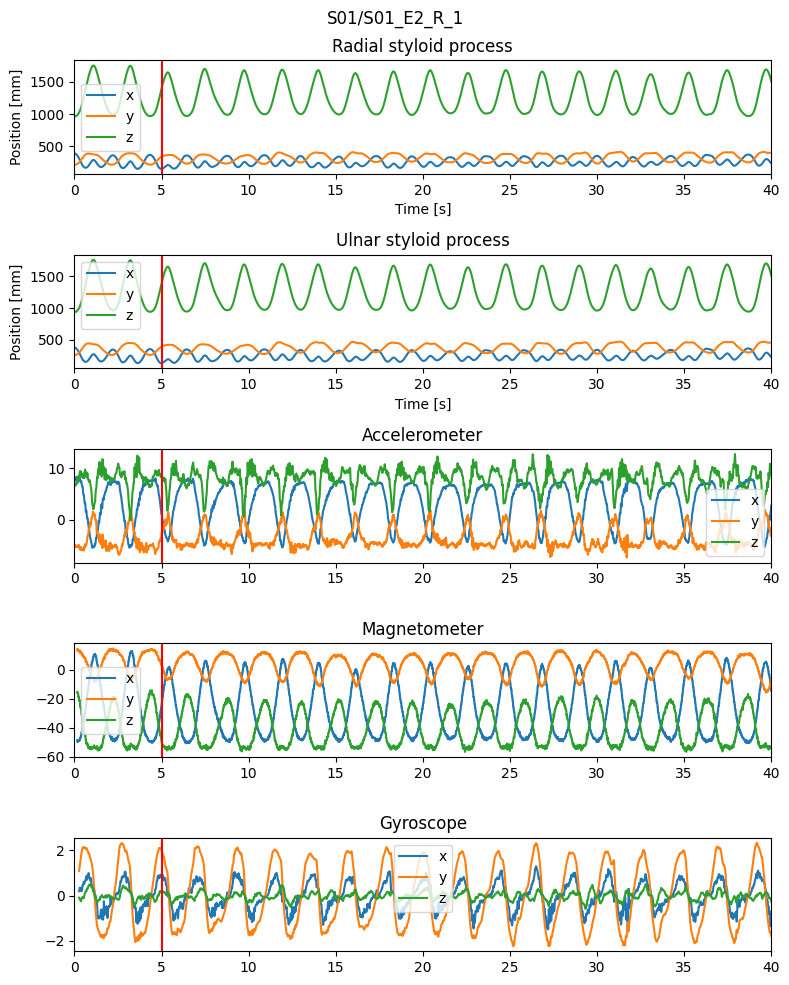

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8, 10))
for ax, df, label in zip(axs[:2], [df_rs, df_us], ["Radial styloid process", "Ulnar styloid process"]):
    N = len(df_rs)
    t = np.arange(N) / 100  # Data is taken at 50 Hz
    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    z = df.iloc[:, 2]
    ax.plot(t, x, label="x")
    ax.plot(t, y, label="y")
    ax.plot(t, z, label="z")
    ax.set_title(label)
    ax.axvline(5, c="r")
    ax.set_xlim(0, 40)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Position [mm]")
    ax.legend()

for ax, sensor_type in zip(axs[2:], df_imu[" Sensor Type"].unique()):
    subdf = df_imu.loc[df_imu[" Sensor Type"] == sensor_type, :]
    t = subdf["Sample Time [s]"].values
    x = subdf["val1"].values
    y = subdf["val2"].values
    z = subdf["val3"].values
    ax.plot(t, x, label="x")
    ax.plot(t, y, label="y")
    ax.plot(t, z, label="z")
    ax.axvline(5, c="r")
    ax.set_xlim(0, 40)
    ax.set_title(sensor_type)
    ax.legend()
plt.suptitle(subject)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib widget

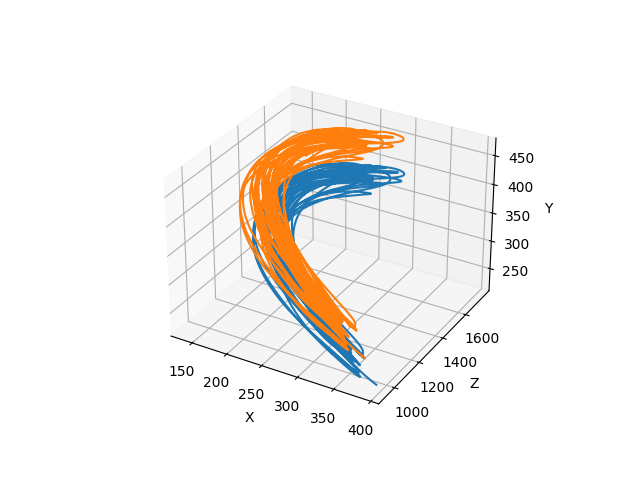

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

for df, label in zip([df_rs, df_us], ["Radial styloid process", "Ulnar styloid process"]):
    x, y, z = zip(*df.values.tolist())
    ax.plot(x, z, zs=y, label=label)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")
plt.show()

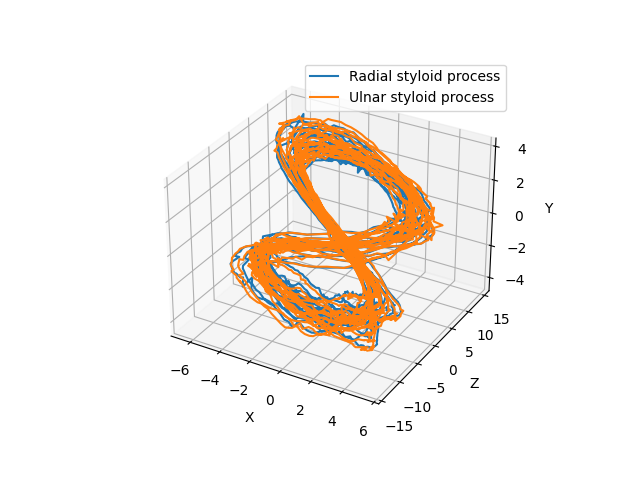

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

for df, label in zip([df_rs, df_us], ["Radial styloid process", "Ulnar styloid process"]):
    x, y, z = zip(*df.values.tolist())
    x, y, z = map(np.diff, (x, y, z))
    ax.plot(x, z, zs=y, label=label)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")
plt.legend()
plt.show()